In [1]:
try:
    # it already installed dependencies
    from torchsummary import summary
    from torchviz import make_dot
except:
    # install graphviz on system
    import platform

    if "Darwin" == platform.system():
        !brew install graphviz
    elif "Linux" == platform.system():
        !sudo apt install graphviz
    else:
        print("go to  https://www.graphviz.org/download/")
    # Next we need to install the following dependencies:
    !pip install torchsummary
    !pip install torch-summary
    !pip install torchviz
    !pip install graphviz
    # import
    from torchsummary import summary
    from torchviz import make_dot

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/ourownstory/neural_prophet/blob/main/tutorials/feature-use/global_local_modeling.ipynb)


# Global Local Model
When fitting a single forecasting model with shared weights using a dataset composed of many time series, we can achieve what is known as a **global model**. It is specially useful in cases in which a single time series may not reflect the entire time series dynamics. In addition, global models provide better generalization and model size saving. In this notebook, we will build a global model using data from the hourly load of the ERCOT region.

When many time series share only "some behaviour" we will need a **global local model**. In the following notebook we will see an example of time series sharing behaviour/weights on all the components except from the trend and seasonality. Therefore, we will also build a global local model using data from the hourly load of the ERCOT region.

This notebook is an adaptation of `global_modeling.ipynb`.

First, we load the data:

In [2]:
if "google.colab" in str(get_ipython()):
    !pip install git+https://github.com/ourownstory/neural_prophet.git # may take a while
    #!pip install neuralprophet # much faster, but may not have the latest upgrades/bugfixes

import pandas as pd
from neuralprophet import NeuralProphet, set_log_level
from neuralprophet import set_random_seed

set_random_seed(10)
set_log_level("ERROR", "INFO")

In [3]:
data_location = "https://raw.githubusercontent.com/ourownstory/neuralprophet-data/main/datasets/"
df_ercot = pd.read_csv(data_location + "multivariate/load_ercot_regions.csv")
df_ercot.head()

,ds,COAST,EAST,FAR_WEST,NORTH,NORTH_C,SOUTHERN,SOUTH_C,WEST
0,2004-01-01 01:00:00,7225.09,877.79,1044.89,745.79,7124.21,1660.45,3639.12,654.61
1,2004-01-01 02:00:00,6994.25,850.75,1032.04,721.34,6854.58,1603.52,3495.16,639.88
2,2004-01-01 03:00:00,6717.42,831.63,1021.10,699.70,6639.48,1527.99,3322.70,623.42
3,2004-01-01 04:00:00,6554.27,823.56,1015.41,691.84,6492.39,1473.89,3201.72,613.49
4,2004-01-01 05:00:00,6511.19,823.38,1009.74,686.76,6452.26,1462.76,3163.74,613.32


We extract the name of the regions which will be later used in the model creation.

In [4]:
regions = list(df_ercot)[1:]

Global models can be enabled when the `df` input of the function has an additional column 'ID', which identifies the different time-series (besides the typical column 'ds', which has the timestamps, and column 'y', which contains the observed values of the time series). We select data from a three-year interval in our example (from 2004 to 2007).

In [5]:
df_global = pd.DataFrame()
for col in regions:
    aux = df_ercot[["ds", col]].copy(deep=True)  # select column associated with region
    aux = aux.iloc[:26301, :].copy(deep=True)  # selects data up to 26301 row (2004 to 2007 time stamps)
    aux = aux.rename(columns={col: "y"})  # rename column of data to 'y' which is compatible with Neural Prophet
    aux["ID"] = col
    df_global = pd.concat((df_global, aux))

We will modify one time series trend and one time series seasonality

WARNING - (py.warnings._showwarnmsg) - /var/folders/g5/gjgtytcx0zb3tysnmlfdy0jr0000gn/T/ipykernel_9646/3026129503.py:5: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  + 2 * df_global[df_global["ID"] == "COAST"].mean().y



<AxesSubplot:>

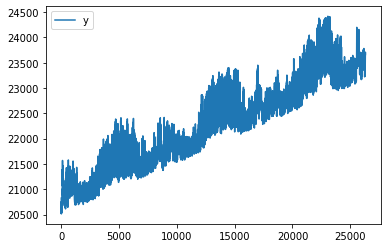

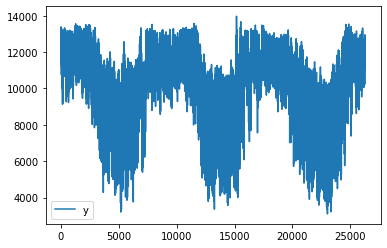

In [6]:
import numpy as np

df_global["y"] = (
    np.where(df_global["ID"] == "COAST", -df_global["y"], df_global["y"])
    + 2 * df_global[df_global["ID"] == "COAST"].mean().y
)
df_global["y"] = np.where(df_global["ID"] == "NORTH", df_global["y"] + 0.1 * df_global.index, df_global["y"])

df_global[df_global["ID"] == "NORTH"].plot()
df_global[df_global["ID"] == "COAST"].plot()

In [7]:
df_local = df_global[df_global["ID"] == "COAST"]
df_local = df_local[["ds", "y"]]

In [8]:
m = NeuralProphet(
)
df_train, df_test = m.split_df(df_global, valid_p=0.33, local_split=True)

## Global Modeling

**Remark:**
- Training a time series only with trend and seasonality components can result in poor performance. The following example is used just to show the new local modelling of multiple time series functionallity.


### DIFFERENT SEASONALITY MODELLING

In [9]:
m = NeuralProphet(
    trend_global_local="global",
    season_global_local="local",
    yearly_seasonality_glocal_mode="global",
    changepoints_range=0.8,
    epochs=1,
    trend_reg=5,
)

In [10]:
m.add_seasonality(period=30, name="monthly", fourier_order=8)

When a pd.DataFrame with an 'ID' column is the input for the `split_df` function, train and validation data are provided in a similar format. For global models, the input data is typically split according to a fraction of the time encompassing all time series (default when there is more than one 'ID' and when `local_split=False`). If the user wants to split each time series locally, the `local_split` parameter must be set to True. In this example, we will split our data into train and test (with a 33% test proportion - 2 years train and 1 year test).

After creating an object of the `NeuralProphet`, a model can be created by calling the `fit` function.

In [11]:
metrics = m.fit(df_train, freq="H")

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
WARNING - (py.warnings._showwarnmsg) - /Users/alfonsogarciadecorral/Desktop/code/neural_prophet/env/lib/python3.8/site-packages/pytorch_lightning/trainer/configuration_validator.py:117: PossibleUserWarning: You defined a `validation_step` but have no `val_dataloader`. Skipping val loop.
  rank_zero_warn(

Loading `train_dataloader` to estimate number of stepping batches.
WARNING - (py.warnings._showwarnmsg) - /Users/alfonsogarciadecorral/Desktop/code/neural_prophet/env/lib/python3.8/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:225: PossibleUserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(



Finding best initial lr:   0%|          | 0/278 [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_steps=278` reached.
Restoring states from the checkpoint path at /Users/alfonsogarciadecorral/Desktop/code/neural_prophet/tutorials/feature-use/.lr_find_a11b891b-2aa8-4f7a-abd0-1786c3bfb927.ckpt
Loading `train_dataloader` to estimate number of stepping batches.

  | Name          | Type             | Params
---------------------------------------------------
0 | metrics_train | MetricCollection | 0     
1 | metrics_val   | MetricCollection | 0     
2 | season_params | ParameterDict    | 172   
---------------------------------------------------
185       Trainable params
0         Non-trainable params
185       Total params
0.001     Total estimated model params size (MB)


Training: 0it [00:00, ?it/s]

`Trainer.fit` stopped: `max_epochs=1` reached.


In [12]:
m.model.config_season.periods["yearly"].global_local

'global'

In [13]:
m.model.config_season.periods

OrderedDict([('yearly',
              Season(resolution=6, period=365.25, arg='auto', global_local='global')),
             ('weekly',
              Season(resolution=3, period=7, arg='auto', global_local='local')),
             ('daily',
              Season(resolution=6, period=1, arg='auto', global_local='local')),
             ('monthly',
              Season(resolution=8, period=30, arg='custom', global_local='global'))])

In [14]:
m.config_season

AllSeason(mode='additive', computation='fourier', reg_lambda=0, yearly_arg='auto', weekly_arg='auto', daily_arg='auto', periods=OrderedDict([('yearly', Season(resolution=6, period=365.25, arg='auto', global_local='global')), ('weekly', Season(resolution=3, period=7, arg='auto', global_local='local')), ('daily', Season(resolution=6, period=1, arg='auto', global_local='local')), ('monthly', Season(resolution=8, period=30, arg='custom', global_local='global'))]), global_local='local', yearly_global_local='global', weekly_global_local='auto', daily_global_local='auto')

In [15]:
future = m.make_future_dataframe(df_test, n_historic_predictions=True)
forecast = m.predict(future)

WARNING - (py.warnings._showwarnmsg) - /Users/alfonsogarciadecorral/Desktop/code/neural_prophet/env/lib/python3.8/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:225: PossibleUserWarning: The dataloader, predict_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(



Predicting: 1102it [00:00, ?it/s]

WARNING - (py.warnings._showwarnmsg) - /Users/alfonsogarciadecorral/Desktop/code/neural_prophet/env/lib/python3.8/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:225: PossibleUserWarning: The dataloader, predict_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(



Predicting: 1102it [00:00, ?it/s]

WARNING - (py.warnings._showwarnmsg) - /Users/alfonsogarciadecorral/Desktop/code/neural_prophet/env/lib/python3.8/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:225: PossibleUserWarning: The dataloader, predict_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(



Predicting: 1102it [00:00, ?it/s]

WARNING - (py.warnings._showwarnmsg) - /Users/alfonsogarciadecorral/Desktop/code/neural_prophet/env/lib/python3.8/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:225: PossibleUserWarning: The dataloader, predict_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(



Predicting: 1102it [00:00, ?it/s]

WARNING - (py.warnings._showwarnmsg) - /Users/alfonsogarciadecorral/Desktop/code/neural_prophet/env/lib/python3.8/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:225: PossibleUserWarning: The dataloader, predict_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(



Predicting: 1102it [00:00, ?it/s]

WARNING - (py.warnings._showwarnmsg) - /Users/alfonsogarciadecorral/Desktop/code/neural_prophet/env/lib/python3.8/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:225: PossibleUserWarning: The dataloader, predict_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(



Predicting: 1102it [00:00, ?it/s]

WARNING - (py.warnings._showwarnmsg) - /Users/alfonsogarciadecorral/Desktop/code/neural_prophet/env/lib/python3.8/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:225: PossibleUserWarning: The dataloader, predict_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(



Predicting: 1102it [00:00, ?it/s]

WARNING - (py.warnings._showwarnmsg) - /Users/alfonsogarciadecorral/Desktop/code/neural_prophet/env/lib/python3.8/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:225: PossibleUserWarning: The dataloader, predict_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(



Predicting: 1102it [00:00, ?it/s]

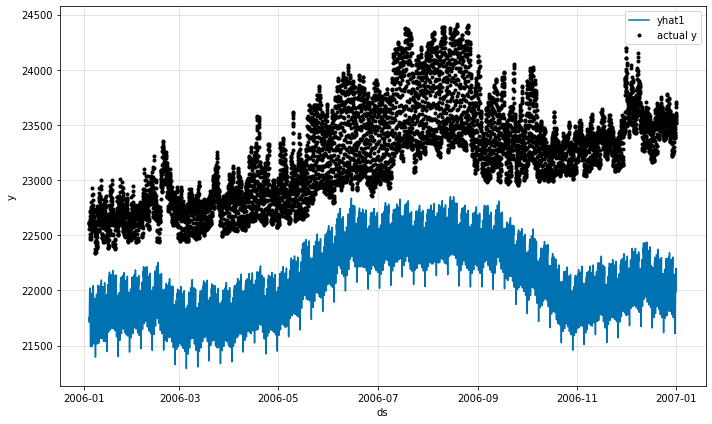

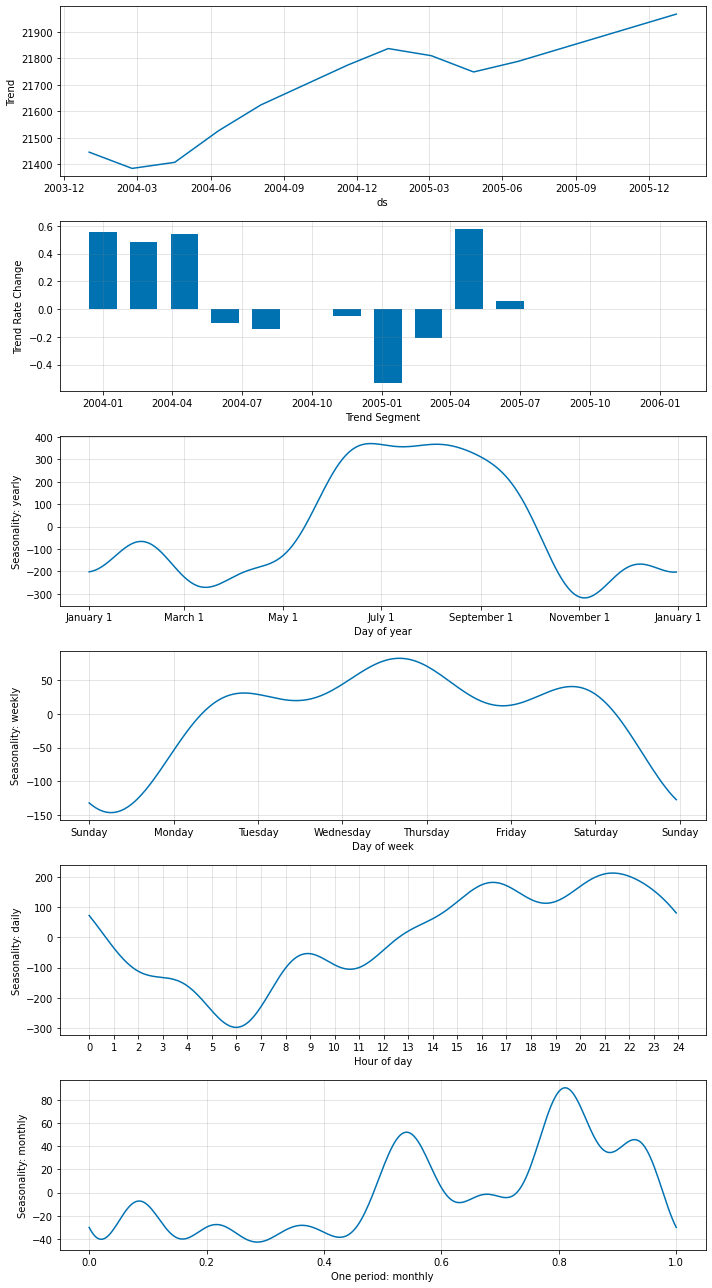

In [16]:
fig = m.plot(forecast[forecast["ID"] == "NORTH"])
fig_param = m.plot_parameters(df_name="NORTH")

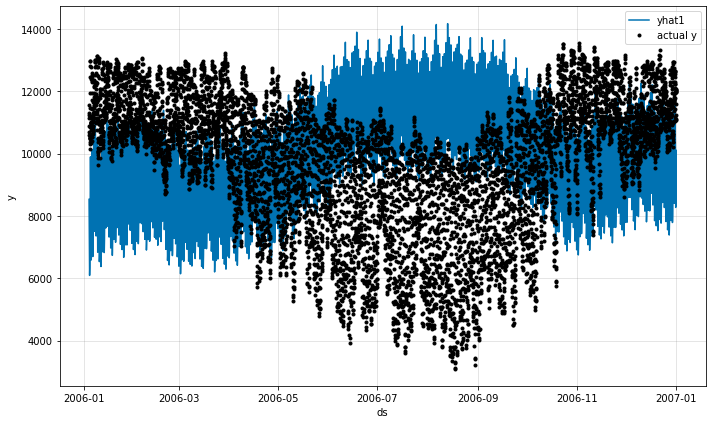

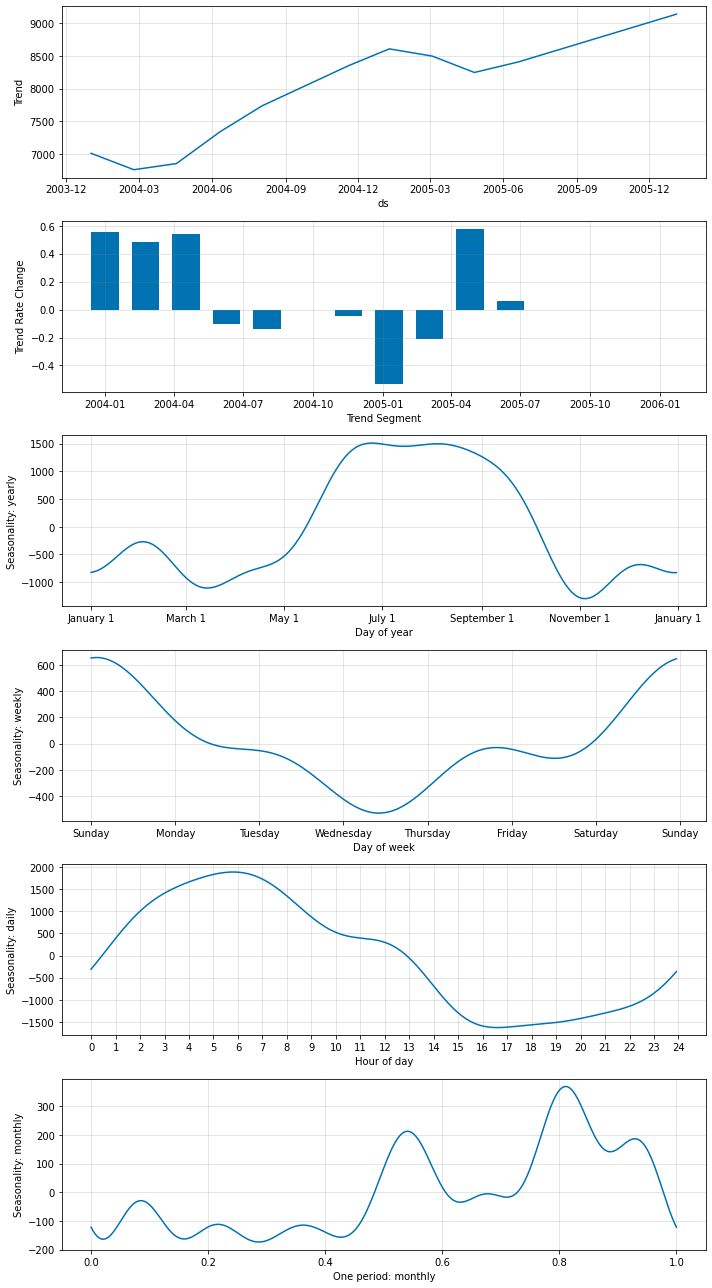

In [17]:
fig = m.plot(forecast[forecast["ID"] == "COAST"])
fig_param = m.plot_parameters(df_name="COAST")

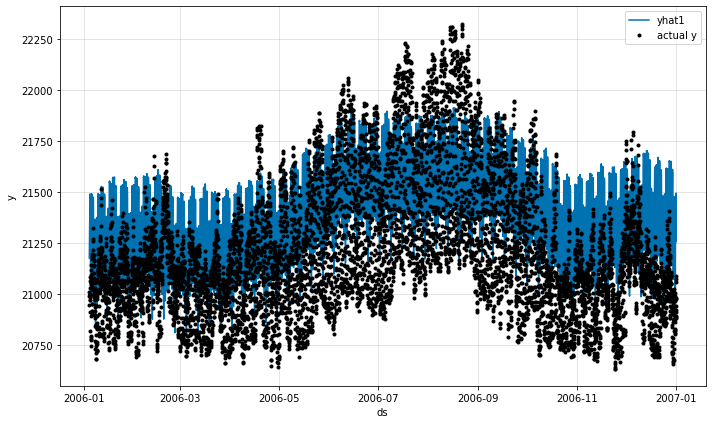

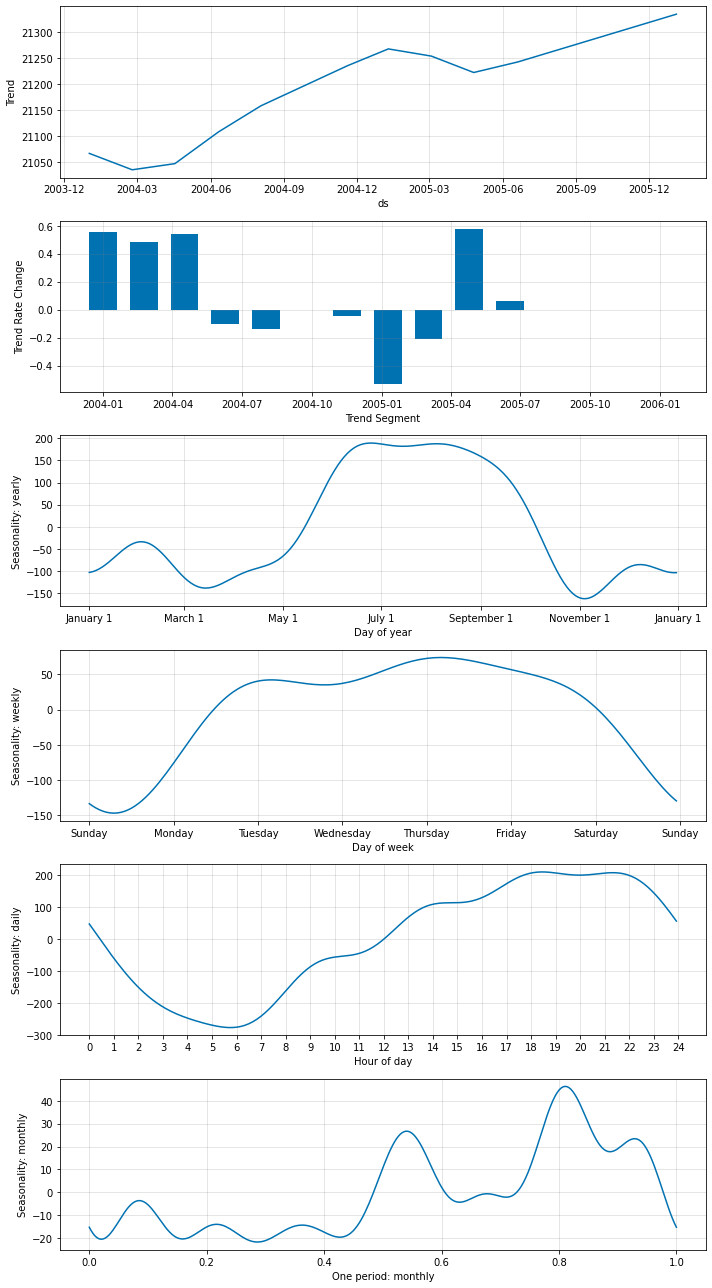

In [18]:
fig = m.plot(forecast[forecast["ID"] == "EAST"])
fig_param = m.plot_parameters(df_name="EAST")

In [19]:
test_metrics_global = m.test(df_test)
test_metrics_global

WARNING - (py.warnings._showwarnmsg) - /Users/alfonsogarciadecorral/Desktop/code/neural_prophet/env/lib/python3.8/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:225: PossibleUserWarning: The dataloader, test_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(



Testing: 0it [00:00, ?it/s]

Loading `train_dataloader` to estimate number of stepping batches.
Loading `train_dataloader` to estimate number of stepping batches.
Loading `train_dataloader` to estimate number of stepping batches.
Loading `train_dataloader` to estimate number of stepping batches.
Loading `train_dataloader` to estimate number of stepping batches.
Loading `train_dataloader` to estimate number of stepping batches.
Loading `train_dataloader` to estimate number of stepping batches.
Loading `train_dataloader` to estimate number of stepping batches.
Loading `train_dataloader` to estimate number of stepping batches.
Loading `train_dataloader` to estimate number of stepping batches.
Loading `train_dataloader` to estimate number of stepping batches.
Loading `train_dataloader` to estimate number of stepping batches.
Loading `train_dataloader` to estimate number of stepping batches.
Loading `train_dataloader` to estimate number of stepping batches.
Loading `train_dataloader` to estimate number of stepping batc

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         Loss_test         │   0.058893729001283646    │
│       RegLoss_test        │   0.016293950378894806    │
└───────────────────────────┴───────────────────────────┘

,Loss_test,RegLoss_test
0,0.058894,0.016294


### GLOCAL TREND 

We will repeat the process above, but for local modelling of trend and seasonality.

In [11]:
m = NeuralProphet(
    trend_global_local="global",
    season_global_local="local",
    glocal_trend_reg=True,
    changepoints_range=0.8,
    epochs=2,
    trend_reg=1,
)

ERROR - (NP.config.__post_init__) - glocal_trend_reg = True. Default glocal_trend_reg value set to 1
ERROR - (NP.config.__post_init__) - Trend modeling is 'global'. Setting the glocal_trend_reg to False


In [47]:
metrics = m.fit(df_train, freq="H")

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
WARNING - (py.warnings._showwarnmsg) - /Users/alfonsogarciadecorral/Desktop/code/neural_prophet/env/lib/python3.8/site-packages/pytorch_lightning/trainer/configuration_validator.py:117: PossibleUserWarning: You defined a `validation_step` but have no `val_dataloader`. Skipping val loop.
  rank_zero_warn(

Loading `train_dataloader` to estimate number of stepping batches.
WARNING - (py.warnings._showwarnmsg) - /Users/alfonsogarciadecorral/Desktop/code/neural_prophet/env/lib/python3.8/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:225: PossibleUserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(



Finding best initial lr:   0%|          | 0/278 [00:00<?, ?it/s]

tensor(0.3409, grad_fn=<MulBackward0>)
tensor(0.3409, grad_fn=<MulBackward0>)
tensor(0.3409, grad_fn=<MulBackward0>)
tensor(0.3409, grad_fn=<MulBackward0>)
tensor(0.3409, grad_fn=<MulBackward0>)
tensor(0.3409, grad_fn=<MulBackward0>)
tensor(0.3409, grad_fn=<MulBackward0>)
tensor(0.3409, grad_fn=<MulBackward0>)
tensor(0.3409, grad_fn=<MulBackward0>)
tensor(0.3409, grad_fn=<MulBackward0>)
tensor(0.3409, grad_fn=<MulBackward0>)
tensor(0.3409, grad_fn=<MulBackward0>)
tensor(0.3409, grad_fn=<MulBackward0>)
tensor(0.3409, grad_fn=<MulBackward0>)
tensor(0.3409, grad_fn=<MulBackward0>)
tensor(0.3409, grad_fn=<MulBackward0>)
tensor(0.3409, grad_fn=<MulBackward0>)
tensor(0.3409, grad_fn=<MulBackward0>)
tensor(0.3409, grad_fn=<MulBackward0>)
tensor(0.3409, grad_fn=<MulBackward0>)
tensor(0.3409, grad_fn=<MulBackward0>)
tensor(0.3409, grad_fn=<MulBackward0>)
tensor(0.3409, grad_fn=<MulBackward0>)
tensor(0.3409, grad_fn=<MulBackward0>)
tensor(0.3409, grad_fn=<MulBackward0>)
tensor(0.3408, grad_fn=<M

tensor(0.0321, grad_fn=<MulBackward0>)
tensor(0.0400, grad_fn=<MulBackward0>)
tensor(0.0477, grad_fn=<MulBackward0>)
tensor(0.0612, grad_fn=<MulBackward0>)
tensor(0.0693, grad_fn=<MulBackward0>)
tensor(0.0712, grad_fn=<MulBackward0>)
tensor(0.0701, grad_fn=<MulBackward0>)
tensor(0.0670, grad_fn=<MulBackward0>)
tensor(0.0630, grad_fn=<MulBackward0>)
tensor(0.0393, grad_fn=<MulBackward0>)
tensor(0.0275, grad_fn=<MulBackward0>)
tensor(0.0392, grad_fn=<MulBackward0>)
tensor(0.0293, grad_fn=<MulBackward0>)
tensor(0.0257, grad_fn=<MulBackward0>)
tensor(0.0460, grad_fn=<MulBackward0>)
tensor(0.0606, grad_fn=<MulBackward0>)
tensor(0.0738, grad_fn=<MulBackward0>)
tensor(0.0953, grad_fn=<MulBackward0>)
tensor(0.1033, grad_fn=<MulBackward0>)
tensor(0.1142, grad_fn=<MulBackward0>)
tensor(0.1076, grad_fn=<MulBackward0>)
tensor(0.1134, grad_fn=<MulBackward0>)
tensor(0.1005, grad_fn=<MulBackward0>)
tensor(0.0767, grad_fn=<MulBackward0>)
tensor(0.1541, grad_fn=<MulBackward0>)
tensor(0.2046, grad_fn=<M

`Trainer.fit` stopped: `max_steps=278` reached.
Restoring states from the checkpoint path at /Users/alfonsogarciadecorral/Desktop/code/neural_prophet/tutorials/feature-use/.lr_find_fcafc53e-1e51-4a95-8f0d-3e21d454a62d.ckpt
Loading `train_dataloader` to estimate number of stepping batches.

  | Name          | Type             | Params
---------------------------------------------------
0 | metrics_train | MetricCollection | 0     
1 | metrics_val   | MetricCollection | 0     
2 | season_params | ParameterDict    | 240   
---------------------------------------------------
337       Trainable params
0         Non-trainable params
337       Total params
0.001     Total estimated model params size (MB)


tensor(0.7229, grad_fn=<MulBackward0>)
tensor(0.4691, grad_fn=<MulBackward0>)
tensor(0.6733, grad_fn=<MulBackward0>)
tensor(0.6320, grad_fn=<MulBackward0>)
tensor(1.1150, grad_fn=<MulBackward0>)
tensor(0.7180, grad_fn=<MulBackward0>)
tensor(0.8409, grad_fn=<MulBackward0>)
tensor(1.9081, grad_fn=<MulBackward0>)


Training: 0it [00:00, ?it/s]

tensor(0.3409, grad_fn=<MulBackward0>)
tensor(0.3405, grad_fn=<MulBackward0>)
tensor(0.3400, grad_fn=<MulBackward0>)
tensor(0.3396, grad_fn=<MulBackward0>)
tensor(0.3392, grad_fn=<MulBackward0>)
tensor(0.3387, grad_fn=<MulBackward0>)
tensor(0.3383, grad_fn=<MulBackward0>)
tensor(0.3378, grad_fn=<MulBackward0>)
tensor(0.3374, grad_fn=<MulBackward0>)
tensor(0.3369, grad_fn=<MulBackward0>)
tensor(0.3365, grad_fn=<MulBackward0>)
tensor(0.3360, grad_fn=<MulBackward0>)
tensor(0.3356, grad_fn=<MulBackward0>)
tensor(0.3351, grad_fn=<MulBackward0>)
tensor(0.3347, grad_fn=<MulBackward0>)
tensor(0.3342, grad_fn=<MulBackward0>)
tensor(0.3337, grad_fn=<MulBackward0>)
tensor(0.3332, grad_fn=<MulBackward0>)
tensor(0.3327, grad_fn=<MulBackward0>)
tensor(0.3322, grad_fn=<MulBackward0>)
tensor(0.3317, grad_fn=<MulBackward0>)
tensor(0.3312, grad_fn=<MulBackward0>)
tensor(0.3307, grad_fn=<MulBackward0>)
tensor(0.3301, grad_fn=<MulBackward0>)
tensor(0.3296, grad_fn=<MulBackward0>)
tensor(0.3290, grad_fn=<M

tensor(0.0263, grad_fn=<MulBackward0>)
tensor(0.0253, grad_fn=<MulBackward0>)
tensor(0.0243, grad_fn=<MulBackward0>)
tensor(0.0234, grad_fn=<MulBackward0>)
tensor(0.0225, grad_fn=<MulBackward0>)
tensor(0.0216, grad_fn=<MulBackward0>)
tensor(0.0207, grad_fn=<MulBackward0>)
tensor(0.0198, grad_fn=<MulBackward0>)
tensor(0.0190, grad_fn=<MulBackward0>)
tensor(0.0182, grad_fn=<MulBackward0>)
tensor(0.0174, grad_fn=<MulBackward0>)
tensor(0.0166, grad_fn=<MulBackward0>)
tensor(0.0159, grad_fn=<MulBackward0>)
tensor(0.0152, grad_fn=<MulBackward0>)
tensor(0.0145, grad_fn=<MulBackward0>)
tensor(0.0138, grad_fn=<MulBackward0>)
tensor(0.0131, grad_fn=<MulBackward0>)
tensor(0.0125, grad_fn=<MulBackward0>)
tensor(0.0119, grad_fn=<MulBackward0>)
tensor(0.0113, grad_fn=<MulBackward0>)
tensor(0.0108, grad_fn=<MulBackward0>)
tensor(0.0103, grad_fn=<MulBackward0>)
tensor(0.0097, grad_fn=<MulBackward0>)
tensor(0.0092, grad_fn=<MulBackward0>)
tensor(0.0088, grad_fn=<MulBackward0>)
tensor(0.0083, grad_fn=<M

tensor(0.0007, grad_fn=<MulBackward0>)
tensor(0.0006, grad_fn=<MulBackward0>)
tensor(0.0007, grad_fn=<MulBackward0>)
tensor(0.0008, grad_fn=<MulBackward0>)
tensor(0.0007, grad_fn=<MulBackward0>)
tensor(0.0006, grad_fn=<MulBackward0>)
tensor(0.0006, grad_fn=<MulBackward0>)
tensor(0.0006, grad_fn=<MulBackward0>)
tensor(0.0006, grad_fn=<MulBackward0>)
tensor(0.0007, grad_fn=<MulBackward0>)
tensor(0.0007, grad_fn=<MulBackward0>)
tensor(0.0008, grad_fn=<MulBackward0>)
tensor(0.0007, grad_fn=<MulBackward0>)
tensor(0.0006, grad_fn=<MulBackward0>)
tensor(0.0007, grad_fn=<MulBackward0>)
tensor(0.0007, grad_fn=<MulBackward0>)
tensor(0.0007, grad_fn=<MulBackward0>)
tensor(0.0007, grad_fn=<MulBackward0>)
tensor(0.0007, grad_fn=<MulBackward0>)
tensor(0.0007, grad_fn=<MulBackward0>)
tensor(0.0008, grad_fn=<MulBackward0>)
tensor(0.0009, grad_fn=<MulBackward0>)
tensor(0.0008, grad_fn=<MulBackward0>)
tensor(0.0008, grad_fn=<MulBackward0>)
tensor(0.0008, grad_fn=<MulBackward0>)
tensor(0.0008, grad_fn=<M

tensor(0.0008, grad_fn=<MulBackward0>)
tensor(0.0007, grad_fn=<MulBackward0>)
tensor(0.0008, grad_fn=<MulBackward0>)
tensor(0.0013, grad_fn=<MulBackward0>)
tensor(0.0017, grad_fn=<MulBackward0>)
tensor(0.0018, grad_fn=<MulBackward0>)
tensor(0.0012, grad_fn=<MulBackward0>)
tensor(0.0009, grad_fn=<MulBackward0>)
tensor(0.0011, grad_fn=<MulBackward0>)
tensor(0.0012, grad_fn=<MulBackward0>)
tensor(0.0009, grad_fn=<MulBackward0>)
tensor(0.0008, grad_fn=<MulBackward0>)
tensor(0.0010, grad_fn=<MulBackward0>)
tensor(0.0010, grad_fn=<MulBackward0>)
tensor(0.0010, grad_fn=<MulBackward0>)
tensor(0.0009, grad_fn=<MulBackward0>)
tensor(0.0007, grad_fn=<MulBackward0>)
tensor(0.0008, grad_fn=<MulBackward0>)
tensor(0.0009, grad_fn=<MulBackward0>)
tensor(0.0011, grad_fn=<MulBackward0>)
tensor(0.0014, grad_fn=<MulBackward0>)
tensor(0.0017, grad_fn=<MulBackward0>)
tensor(0.0014, grad_fn=<MulBackward0>)
tensor(0.0009, grad_fn=<MulBackward0>)
tensor(0.0007, grad_fn=<MulBackward0>)
tensor(0.0007, grad_fn=<M

tensor(0.0012, grad_fn=<MulBackward0>)
tensor(0.0012, grad_fn=<MulBackward0>)
tensor(0.0013, grad_fn=<MulBackward0>)
tensor(0.0013, grad_fn=<MulBackward0>)
tensor(0.0013, grad_fn=<MulBackward0>)
tensor(0.0009, grad_fn=<MulBackward0>)
tensor(0.0004, grad_fn=<MulBackward0>)
tensor(0.0005, grad_fn=<MulBackward0>)
tensor(0.0011, grad_fn=<MulBackward0>)
tensor(0.0013, grad_fn=<MulBackward0>)
tensor(0.0014, grad_fn=<MulBackward0>)
tensor(0.0013, grad_fn=<MulBackward0>)
tensor(0.0011, grad_fn=<MulBackward0>)
tensor(0.0015, grad_fn=<MulBackward0>)
tensor(0.0014, grad_fn=<MulBackward0>)
tensor(0.0011, grad_fn=<MulBackward0>)
tensor(0.0009, grad_fn=<MulBackward0>)
tensor(0.0010, grad_fn=<MulBackward0>)
tensor(0.0015, grad_fn=<MulBackward0>)
tensor(0.0018, grad_fn=<MulBackward0>)
tensor(0.0012, grad_fn=<MulBackward0>)
tensor(0.0007, grad_fn=<MulBackward0>)
tensor(0.0005, grad_fn=<MulBackward0>)
tensor(0.0008, grad_fn=<MulBackward0>)
tensor(0.0011, grad_fn=<MulBackward0>)
tensor(0.0013, grad_fn=<M

tensor(0.0007, grad_fn=<MulBackward0>)
tensor(0.0005, grad_fn=<MulBackward0>)
tensor(0.0005, grad_fn=<MulBackward0>)
tensor(0.0006, grad_fn=<MulBackward0>)
tensor(0.0007, grad_fn=<MulBackward0>)
tensor(0.0009, grad_fn=<MulBackward0>)
tensor(0.0009, grad_fn=<MulBackward0>)
tensor(0.0010, grad_fn=<MulBackward0>)
tensor(0.0009, grad_fn=<MulBackward0>)
tensor(0.0010, grad_fn=<MulBackward0>)
tensor(0.0010, grad_fn=<MulBackward0>)
tensor(0.0009, grad_fn=<MulBackward0>)
tensor(0.0007, grad_fn=<MulBackward0>)
tensor(0.0007, grad_fn=<MulBackward0>)
tensor(0.0007, grad_fn=<MulBackward0>)
tensor(0.0007, grad_fn=<MulBackward0>)
tensor(0.0007, grad_fn=<MulBackward0>)
tensor(0.0006, grad_fn=<MulBackward0>)
tensor(0.0007, grad_fn=<MulBackward0>)
tensor(0.0006, grad_fn=<MulBackward0>)
tensor(0.0007, grad_fn=<MulBackward0>)
tensor(0.0010, grad_fn=<MulBackward0>)
tensor(0.0012, grad_fn=<MulBackward0>)
tensor(0.0014, grad_fn=<MulBackward0>)
tensor(0.0012, grad_fn=<MulBackward0>)
tensor(0.0010, grad_fn=<M

tensor(0.0007, grad_fn=<MulBackward0>)
tensor(0.0007, grad_fn=<MulBackward0>)
tensor(0.0007, grad_fn=<MulBackward0>)
tensor(0.0007, grad_fn=<MulBackward0>)
tensor(0.0006, grad_fn=<MulBackward0>)
tensor(0.0006, grad_fn=<MulBackward0>)
tensor(0.0006, grad_fn=<MulBackward0>)
tensor(0.0007, grad_fn=<MulBackward0>)
tensor(0.0008, grad_fn=<MulBackward0>)
tensor(0.0009, grad_fn=<MulBackward0>)
tensor(0.0009, grad_fn=<MulBackward0>)
tensor(0.0008, grad_fn=<MulBackward0>)
tensor(0.0007, grad_fn=<MulBackward0>)
tensor(0.0007, grad_fn=<MulBackward0>)
tensor(0.0008, grad_fn=<MulBackward0>)
tensor(0.0008, grad_fn=<MulBackward0>)
tensor(0.0008, grad_fn=<MulBackward0>)
tensor(0.0007, grad_fn=<MulBackward0>)
tensor(0.0006, grad_fn=<MulBackward0>)
tensor(0.0004, grad_fn=<MulBackward0>)
tensor(0.0005, grad_fn=<MulBackward0>)
tensor(0.0006, grad_fn=<MulBackward0>)
tensor(0.0007, grad_fn=<MulBackward0>)
tensor(0.0008, grad_fn=<MulBackward0>)
tensor(0.0009, grad_fn=<MulBackward0>)
tensor(0.0009, grad_fn=<M

tensor(0.0008, grad_fn=<MulBackward0>)
tensor(0.0008, grad_fn=<MulBackward0>)
tensor(0.0007, grad_fn=<MulBackward0>)
tensor(0.0006, grad_fn=<MulBackward0>)
tensor(0.0006, grad_fn=<MulBackward0>)
tensor(0.0005, grad_fn=<MulBackward0>)
tensor(0.0005, grad_fn=<MulBackward0>)
tensor(0.0006, grad_fn=<MulBackward0>)
tensor(0.0006, grad_fn=<MulBackward0>)
tensor(0.0007, grad_fn=<MulBackward0>)
tensor(0.0007, grad_fn=<MulBackward0>)
tensor(0.0007, grad_fn=<MulBackward0>)
tensor(0.0007, grad_fn=<MulBackward0>)
tensor(0.0007, grad_fn=<MulBackward0>)
tensor(0.0007, grad_fn=<MulBackward0>)
tensor(0.0007, grad_fn=<MulBackward0>)
tensor(0.0007, grad_fn=<MulBackward0>)
tensor(0.0007, grad_fn=<MulBackward0>)
tensor(0.0006, grad_fn=<MulBackward0>)
tensor(0.0006, grad_fn=<MulBackward0>)
tensor(0.0006, grad_fn=<MulBackward0>)
tensor(0.0006, grad_fn=<MulBackward0>)
tensor(0.0006, grad_fn=<MulBackward0>)
tensor(0.0006, grad_fn=<MulBackward0>)
tensor(0.0007, grad_fn=<MulBackward0>)
tensor(0.0007, grad_fn=<M

tensor(0.0006, grad_fn=<MulBackward0>)
tensor(0.0006, grad_fn=<MulBackward0>)
tensor(0.0006, grad_fn=<MulBackward0>)
tensor(0.0005, grad_fn=<MulBackward0>)
tensor(0.0005, grad_fn=<MulBackward0>)
tensor(0.0006, grad_fn=<MulBackward0>)
tensor(0.0006, grad_fn=<MulBackward0>)
tensor(0.0006, grad_fn=<MulBackward0>)
tensor(0.0006, grad_fn=<MulBackward0>)
tensor(0.0006, grad_fn=<MulBackward0>)
tensor(0.0006, grad_fn=<MulBackward0>)
tensor(0.0006, grad_fn=<MulBackward0>)
tensor(0.0006, grad_fn=<MulBackward0>)
tensor(0.0006, grad_fn=<MulBackward0>)
tensor(0.0006, grad_fn=<MulBackward0>)
tensor(0.0006, grad_fn=<MulBackward0>)
tensor(0.0006, grad_fn=<MulBackward0>)
tensor(0.0006, grad_fn=<MulBackward0>)
tensor(0.0006, grad_fn=<MulBackward0>)
tensor(0.0006, grad_fn=<MulBackward0>)
tensor(0.0006, grad_fn=<MulBackward0>)
tensor(0.0006, grad_fn=<MulBackward0>)
tensor(0.0006, grad_fn=<MulBackward0>)
tensor(0.0006, grad_fn=<MulBackward0>)
tensor(0.0006, grad_fn=<MulBackward0>)
tensor(0.0006, grad_fn=<M

tensor(0.0006, grad_fn=<MulBackward0>)
tensor(0.0006, grad_fn=<MulBackward0>)
tensor(0.0006, grad_fn=<MulBackward0>)
tensor(0.0006, grad_fn=<MulBackward0>)
tensor(0.0006, grad_fn=<MulBackward0>)
tensor(0.0006, grad_fn=<MulBackward0>)
tensor(0.0006, grad_fn=<MulBackward0>)
tensor(0.0006, grad_fn=<MulBackward0>)
tensor(0.0006, grad_fn=<MulBackward0>)
tensor(0.0006, grad_fn=<MulBackward0>)
tensor(0.0006, grad_fn=<MulBackward0>)
tensor(0.0006, grad_fn=<MulBackward0>)
tensor(0.0006, grad_fn=<MulBackward0>)
tensor(0.0006, grad_fn=<MulBackward0>)
tensor(0.0006, grad_fn=<MulBackward0>)
tensor(0.0006, grad_fn=<MulBackward0>)
tensor(0.0006, grad_fn=<MulBackward0>)
tensor(0.0006, grad_fn=<MulBackward0>)
tensor(0.0006, grad_fn=<MulBackward0>)
tensor(0.0006, grad_fn=<MulBackward0>)
tensor(0.0006, grad_fn=<MulBackward0>)
tensor(0.0006, grad_fn=<MulBackward0>)
tensor(0.0006, grad_fn=<MulBackward0>)
tensor(0.0006, grad_fn=<MulBackward0>)
tensor(0.0006, grad_fn=<MulBackward0>)
tensor(0.0006, grad_fn=<M

`Trainer.fit` stopped: `max_epochs=2` reached.


tensor(0.0006, grad_fn=<MulBackward0>)
tensor(0.0006, grad_fn=<MulBackward0>)
tensor(0.0006, grad_fn=<MulBackward0>)
tensor(0.0006, grad_fn=<MulBackward0>)
tensor(0.0006, grad_fn=<MulBackward0>)
tensor(0.0006, grad_fn=<MulBackward0>)
tensor(0.0006, grad_fn=<MulBackward0>)
tensor(0.0006, grad_fn=<MulBackward0>)
tensor(0.0006, grad_fn=<MulBackward0>)
tensor(0.0006, grad_fn=<MulBackward0>)
tensor(0.0006, grad_fn=<MulBackward0>)
tensor(0.0006, grad_fn=<MulBackward0>)
tensor(0.0006, grad_fn=<MulBackward0>)
tensor(0.0006, grad_fn=<MulBackward0>)
tensor(0.0006, grad_fn=<MulBackward0>)


In [48]:
future = m.make_future_dataframe(df_test, n_historic_predictions=True)
forecast = m.predict(future)

WARNING - (py.warnings._showwarnmsg) - /Users/alfonsogarciadecorral/Desktop/code/neural_prophet/env/lib/python3.8/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:225: PossibleUserWarning: The dataloader, predict_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(



Predicting: 1102it [00:00, ?it/s]

WARNING - (py.warnings._showwarnmsg) - /Users/alfonsogarciadecorral/Desktop/code/neural_prophet/env/lib/python3.8/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:225: PossibleUserWarning: The dataloader, predict_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(



Predicting: 1102it [00:00, ?it/s]

WARNING - (py.warnings._showwarnmsg) - /Users/alfonsogarciadecorral/Desktop/code/neural_prophet/env/lib/python3.8/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:225: PossibleUserWarning: The dataloader, predict_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(



Predicting: 1102it [00:00, ?it/s]

WARNING - (py.warnings._showwarnmsg) - /Users/alfonsogarciadecorral/Desktop/code/neural_prophet/env/lib/python3.8/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:225: PossibleUserWarning: The dataloader, predict_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(



Predicting: 1102it [00:00, ?it/s]

WARNING - (py.warnings._showwarnmsg) - /Users/alfonsogarciadecorral/Desktop/code/neural_prophet/env/lib/python3.8/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:225: PossibleUserWarning: The dataloader, predict_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(



Predicting: 1102it [00:00, ?it/s]

WARNING - (py.warnings._showwarnmsg) - /Users/alfonsogarciadecorral/Desktop/code/neural_prophet/env/lib/python3.8/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:225: PossibleUserWarning: The dataloader, predict_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(



Predicting: 1102it [00:00, ?it/s]

WARNING - (py.warnings._showwarnmsg) - /Users/alfonsogarciadecorral/Desktop/code/neural_prophet/env/lib/python3.8/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:225: PossibleUserWarning: The dataloader, predict_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(



Predicting: 1102it [00:00, ?it/s]

WARNING - (py.warnings._showwarnmsg) - /Users/alfonsogarciadecorral/Desktop/code/neural_prophet/env/lib/python3.8/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:225: PossibleUserWarning: The dataloader, predict_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(



Predicting: 1102it [00:00, ?it/s]

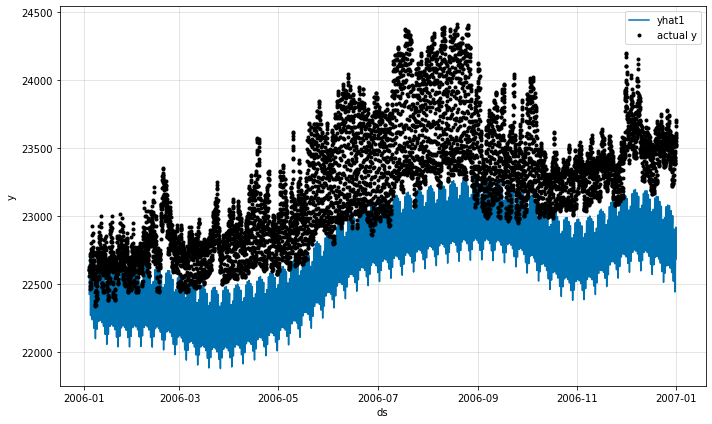

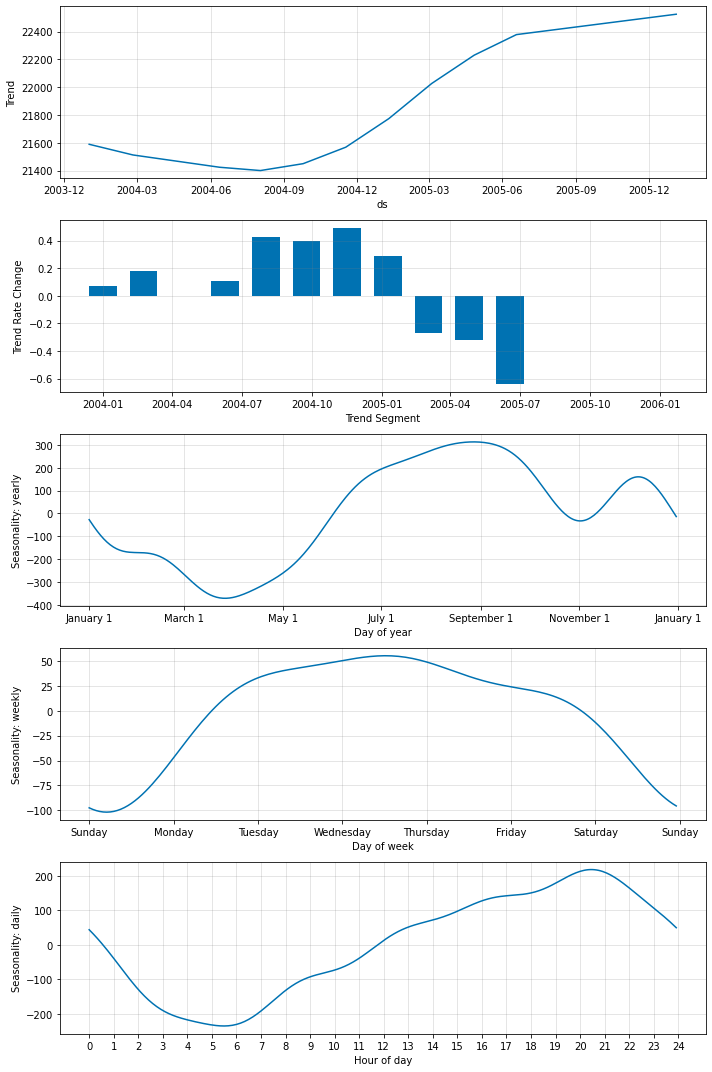

In [35]:
fig = m.plot(forecast[forecast["ID"] == "NORTH"])
fig_param = m.plot_parameters(df_name="NORTH")

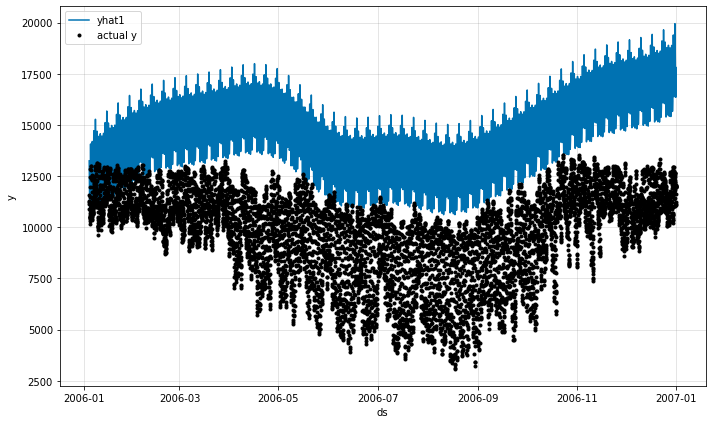

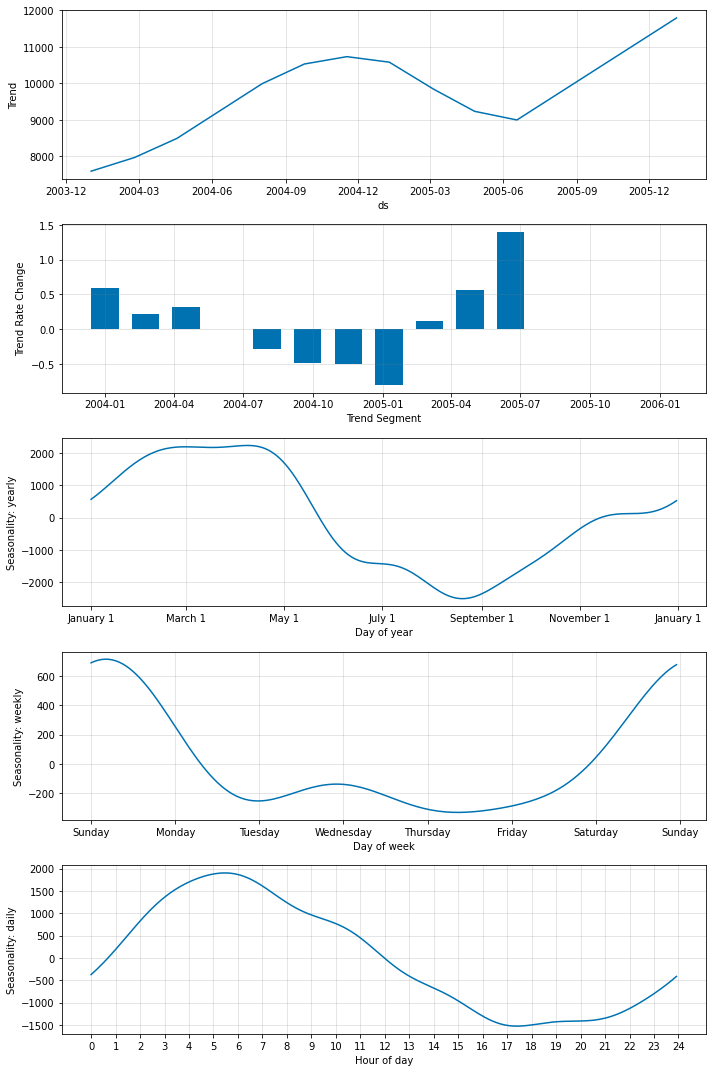

In [36]:
fig = m.plot(forecast[forecast["ID"] == "COAST"])
fig_param = m.plot_parameters(df_name="COAST")

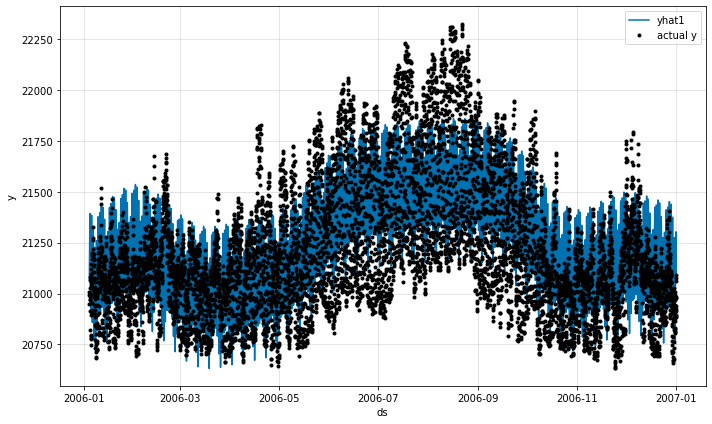

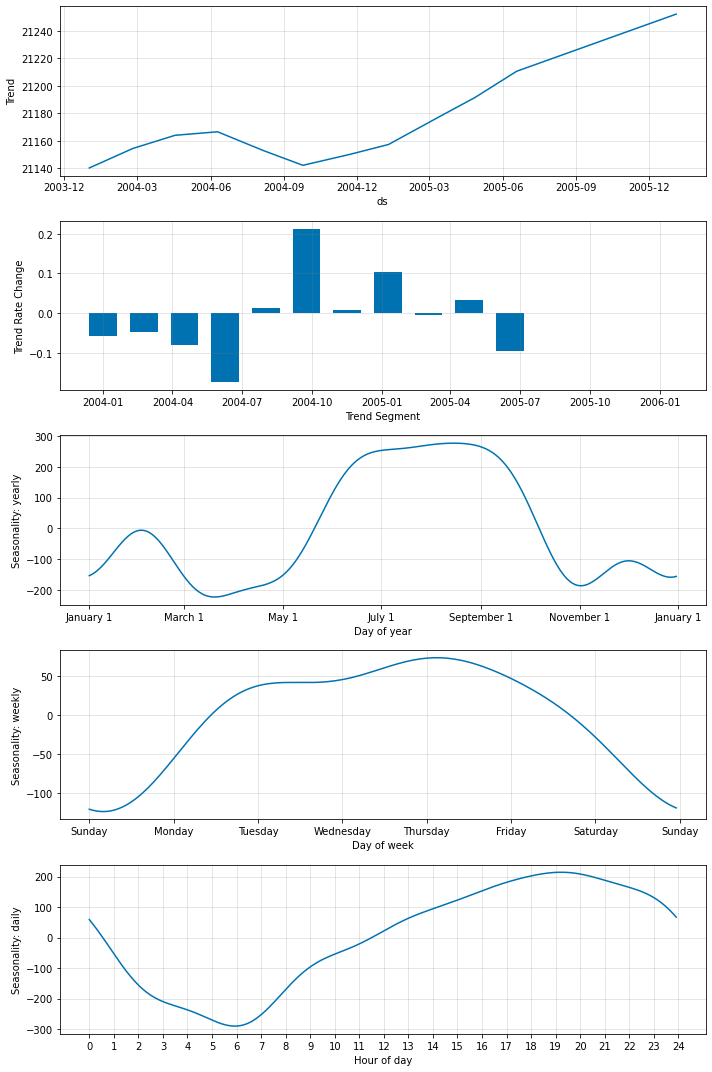

In [37]:
fig = m.plot(forecast[forecast["ID"] == "EAST"])
fig_param = m.plot_parameters(df_name="EAST")

In [38]:
test_metrics_local = m.test(df_test)
test_metrics_local

WARNING - (py.warnings._showwarnmsg) - /Users/alfonsogarciadecorral/Desktop/code/neural_prophet/env/lib/python3.8/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:225: PossibleUserWarning: The dataloader, test_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(



Testing: 0it [00:00, ?it/s]

Loading `train_dataloader` to estimate number of stepping batches.
Loading `train_dataloader` to estimate number of stepping batches.
Loading `train_dataloader` to estimate number of stepping batches.
Loading `train_dataloader` to estimate number of stepping batches.
Loading `train_dataloader` to estimate number of stepping batches.
Loading `train_dataloader` to estimate number of stepping batches.
Loading `train_dataloader` to estimate number of stepping batches.
Loading `train_dataloader` to estimate number of stepping batches.
Loading `train_dataloader` to estimate number of stepping batches.
Loading `train_dataloader` to estimate number of stepping batches.
Loading `train_dataloader` to estimate number of stepping batches.
Loading `train_dataloader` to estimate number of stepping batches.
Loading `train_dataloader` to estimate number of stepping batches.
Loading `train_dataloader` to estimate number of stepping batches.
Loading `train_dataloader` to estimate number of stepping batc

tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])


Loading `train_dataloader` to estimate number of stepping batches.
Loading `train_dataloader` to estimate number of stepping batches.
Loading `train_dataloader` to estimate number of stepping batches.
Loading `train_dataloader` to estimate number of stepping batches.
Loading `train_dataloader` to estimate number of stepping batches.
Loading `train_dataloader` to estimate number of stepping batches.
Loading `train_dataloader` to estimate number of stepping batches.
Loading `train_dataloader` to estimate number of stepping batches.
Loading `train_dataloader` to estimate number of stepping batches.
Loading `train_dataloader` to estimate number of stepping batches.
Loading `train_dataloader` to estimate number of stepping batches.
Loading `train_dataloader` to estimate number of stepping batches.
Loading `train_dataloader` to estimate number of stepping batches.
Loading `train_dataloader` to estimate number of stepping batches.
Loading `train_dataloader` to estimate number of stepping batc

tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])


Loading `train_dataloader` to estimate number of stepping batches.
Loading `train_dataloader` to estimate number of stepping batches.
Loading `train_dataloader` to estimate number of stepping batches.
Loading `train_dataloader` to estimate number of stepping batches.
Loading `train_dataloader` to estimate number of stepping batches.
Loading `train_dataloader` to estimate number of stepping batches.
Loading `train_dataloader` to estimate number of stepping batches.
Loading `train_dataloader` to estimate number of stepping batches.
Loading `train_dataloader` to estimate number of stepping batches.
Loading `train_dataloader` to estimate number of stepping batches.
Loading `train_dataloader` to estimate number of stepping batches.
Loading `train_dataloader` to estimate number of stepping batches.
Loading `train_dataloader` to estimate number of stepping batches.
Loading `train_dataloader` to estimate number of stepping batches.
Loading `train_dataloader` to estimate number of stepping batc

tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])


Loading `train_dataloader` to estimate number of stepping batches.
Loading `train_dataloader` to estimate number of stepping batches.
Loading `train_dataloader` to estimate number of stepping batches.
Loading `train_dataloader` to estimate number of stepping batches.
Loading `train_dataloader` to estimate number of stepping batches.
Loading `train_dataloader` to estimate number of stepping batches.
Loading `train_dataloader` to estimate number of stepping batches.
Loading `train_dataloader` to estimate number of stepping batches.
Loading `train_dataloader` to estimate number of stepping batches.
Loading `train_dataloader` to estimate number of stepping batches.


tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         Loss_test         │    0.03703480213880539    │
│       RegLoss_test        │   0.0020284210331737995   │
└───────────────────────────┴───────────────────────────┘

,Loss_test,RegLoss_test
0,0.037035,0.002028


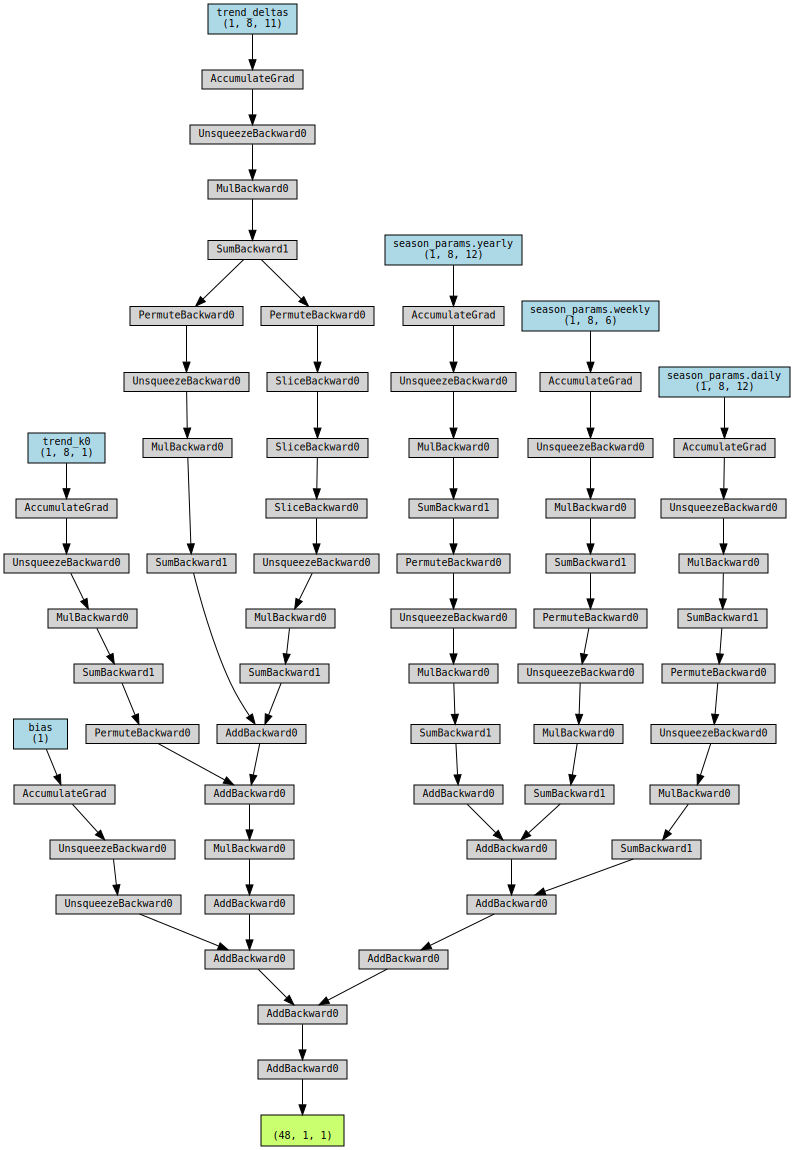

In [31]:
fig = make_dot(m.model.train_epoch_prediction, params=dict(m.model.named_parameters()))
# fig_glob.render(filename='img/fig_glob')
display(fig)